# Introduction

As a result from our train conversation I prepared the following IPython notebook that compares different alternatives to crowdwing distance as a "secondary" criterion in nondominated sorting.

In case you want to run this notebook on your own you need IPython and the DEAP library (https://www.github.com/DEAP/deap).

In [156]:
import time, array, random, copy, math

import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from deap import algorithms, base, benchmarks, tools, creator

import deap.benchmarks.tools as bt
from itertools import chain
from operator import attrgetter, itemgetter

For the first experiments we use DTLZ2, which is a reasonably simple problem, and 5 objectives.

In [3]:
BOUND_LOW, BOUND_UP = 0.0, 1.0
number_of_objs = 5
number_of_variables = 30

In [4]:
def dtlz2_instance(ind):
    return benchmarks.dtlz2(ind, number_of_objs)

Here we create the fitness assignment function as a minimization problem with 5 objectives.

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)* number_of_objs)
creator.create("Individual", array.array, typecode='d', 
               fitness=creator.FitnessMin)

The `toolbox` contains the configuration of the algorithm:
* how to create an individual,
* how to create a population,
* the evolutionary operators,
* etc.

In [6]:
toolbox = base.Toolbox()
toolbox.register("evaluate", dtlz2_instance)

In [7]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, number_of_variables)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [8]:
toolbox.register("mate", tools.cxSimulatedBinaryBounded, 
                 low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, 
                 low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/number_of_variables)

In [9]:
toolbox.pop_size = 50    # population size
toolbox.max_gen = 100    # max number of iteration
toolbox.mut_prob = 0.05  # mutation probability

The `stats` object describes the statistics we want to collect. For flexibility, we will store whole populations for every iteration.

In [10]:
stats = tools.Statistics()
stats.register("pop", copy.deepcopy)

Using DEAP is very simple to code a flexible NSGA-II whose internal functions can be modified via the `toolbox`.

In [11]:
def run_algo(toolbox, stats=stats, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)
    pop = toolbox.select(pop, len(pop))
    res, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=verbose)
    return logbook

We now code the alternatives to crowding distance that we will test.

In [12]:
def assign_crowding_distance(individuals):
    distances = [0.0] * len(individuals)
    crowd = [(ind.fitness.values, i) for i, ind in enumerate(individuals)]
    
    nobj = len(individuals[0].fitness.values)
    
    for i in xrange(nobj):
        crowd.sort(key=lambda element: element[0][i])
        distances[crowd[0][1]] = float("inf")
        distances[crowd[-1][1]] = float("inf")
        if crowd[-1][0][i] == crowd[0][0][i]:
            continue
        norm = nobj * float(crowd[-1][0][i] - crowd[0][0][i])
        for prev, cur, next in zip(crowd[:-2], crowd[1:-1], crowd[2:]):
            distances[cur[1]] += (next[0][i] - prev[0][i]) / norm

    for i, dist in enumerate(distances):
        individuals[i].fitness.crowding_dist = dist

In [13]:
def assign_random(individuals):
    if len(individuals) == 0:
        return
    for ind in individuals:
        ind.fitness.distance = random.random()

In [14]:
def assign_random_keep_extremes(individuals):
    if len(individuals) == 0:
        return
    
    distances = [0.0] * len(individuals)
    crowd = [(ind.fitness.values, i) for i, ind in enumerate(individuals)]
    
    nobj = len(individuals[0].fitness.values)
    
    for i in range(nobj):
        crowd.sort(key=lambda element: element[0][i])
        distances[crowd[0][1]] = float("inf")
        distances[crowd[-1][1]] = float("inf")
        if crowd[-1][0][i] == crowd[0][0][i]:
            continue
    
    for i,ind in enumerate(individuals):
        if distances[i] == 0:
            dists = [other for other in individuals if not ind == other]
            if not dists:
                ind.fitness.distance = float("inf")
            else:
                ind.fitness.distance = random.random()
        else:
            ind.fitness.distance = distances[i]

In [15]:
def compute_distance_matrix(individuals):
    matrix = np.zeros((len(individuals),len(individuals)))
    for i in range(len(individuals)-1):
        for j in range(i+1, len(individuals)):
            matrix[i][j] = euclidean(individuals[i].fitness.values, individuals[j].fitness.values)
            matrix[j][i] = matrix[i][j]
    return matrix

In [16]:
def assign_euclidean(individuals):
    dist_matrix = compute_distance_matrix(individuals)
    
    for i,ind in enumerate(individuals):
        dists = [dist_matrix[i][j] for j in range(len(individuals)) if not i == j]
        if not dists:
            ind.fitness.distance = float("inf")
        else:
            ind.fitness.distance = min(dists)

In [17]:
def assign_euclidean_keep_extremes(individuals):  
    if len(individuals) == 0:
        return
    
    distances = [0.0] * len(individuals)
    crowd = [(ind.fitness.values, i) for i, ind in enumerate(individuals)]
    
    nobj = len(individuals[0].fitness.values)
    
    for i in range(nobj):
        crowd.sort(key=lambda element: element[0][i])
        distances[crowd[0][1]] = float("inf")
        distances[crowd[-1][1]] = float("inf")
        if crowd[-1][0][i] == crowd[0][0][i]:
            continue
    
    dist_matrix = compute_distance_matrix(individuals)
    
    for i,ind in enumerate(individuals):
        if distances[i] == 0:
            dists = [dist_matrix[i][j] for j in range(len(individuals)) if not i == j]
            if not dists:
                ind.fitness.distance = float("inf")
            else:
                ind.fitness.distance = min(dists)
        else:
            ind.fitness.distance = distances[i]

NSGA-II selection must be modified to deal with the crowding distance alternatives.

In [18]:
def selection_custom(individuals, k, nd='standard', 
                     distance=tools.emo.assignCrowdingDist,
                     key='fitness.crowding_dist', reverse=True):
    if nd == 'standard':
        pareto_fronts = tools.sortNondominated(individuals, k)
    elif nd == 'log':
        pareto_fronts = tools.sortLogNondominated(individuals, k)
    else:
        raise Exception('selNSGA2: The choice of non-dominated sorting '
                        'method "{0}" is invalid.'.format(nd))

    for front in pareto_fronts:
        distance(front)
    
    chosen = list(chain(*pareto_fronts[:-1]))
    k = k - len(chosen)
    if k > 0:
        sorted_front = sorted(pareto_fronts[-1], key=attrgetter(key), reverse=reverse)
        chosen.extend(sorted_front[:k])
        
    return chosen

# Running the experiments

Repeat the experiments `number_of_runs` times.

In [19]:
number_of_runs = 30

Using Python `multiprocessing` module for speeding up the experiments by using multi-core parallelization.

In [20]:
from multiprocessing import Pool

By default pool will have a number of proceses equal to the number of cores of your CPU.

Results will be stored on the dictionary `logbooks`.

In [21]:
logbooks = {}

## Running "traditional" crowding distance

In [22]:
toolbox.register("select", tools.selNSGA2)

In [23]:
pool = Pool()

In [24]:
%time logbooks['01. Crowding distance'] = pool.map(run_algo, [toolbox] * number_of_runs)

CPU times: user 3.07 s, sys: 253 ms, total: 3.33 s
Wall time: 43 s


In [25]:
pool.close()

## Running random selection

In [26]:
def sel_random(pop, k):
    return selection_custom(pop, k, distance=assign_random, 
                                  key='fitness.distance')

In [27]:
toolbox.register("select", sel_random)

In [28]:
pool = Pool()

In [29]:
%time logbooks['02. random'] = pool.map(run_algo, [toolbox] * number_of_runs)

CPU times: user 3.09 s, sys: 353 ms, total: 3.45 s
Wall time: 46.5 s


In [30]:
pool.close()

## Running random but keeping the extreme points

In [31]:
def sel_random_keep_extremes(pop, k):
    return selection_custom(pop, k, distance=assign_random_keep_extremes, 
                                  key='fitness.distance')

In [32]:
toolbox.register("select", sel_random_keep_extremes)

In [33]:
pool = Pool()

In [34]:
%time logbooks['03. random with extremes'] = pool.map(run_algo, [toolbox] * number_of_runs)

CPU times: user 3.16 s, sys: 413 ms, total: 3.57 s
Wall time: 52.1 s


In [35]:
pool.close()

## Running Euclidean distance

In [36]:
def sel_euclidean(pop, k):
    return selection_custom(pop, k, distance=assign_euclidean, 
                                  key='fitness.distance')

In [37]:
toolbox.register("select", sel_euclidean)

In [38]:
pool = Pool()

In [39]:
%time logbooks['04. Euclidean distance'] = pool.map(run_algo, [toolbox] * number_of_runs)

CPU times: user 3.44 s, sys: 1.14 s, total: 4.58 s
Wall time: 6min 13s


In [40]:
pool.close()

## Running Euclidean distance and keeping the extremes

In [41]:
def sel_euclidean_keep_extremes(pop, k):
    return selection_custom(pop, k, distance=assign_euclidean_keep_extremes, 
                                  key='fitness.distance')

In [42]:
toolbox.register("select", sel_euclidean_keep_extremes)

In [43]:
pool = Pool()

In [44]:
%time logbooks['05. Euclidean distance with extremes'] = pool.map(run_algo, [toolbox] * number_of_runs)

CPU times: user 3.35 s, sys: 535 ms, total: 3.89 s
Wall time: 4min 48s


In [45]:
pool.close()

# Plotting the results

For each method, we will plot the values of the hypervolume indicator of each generation.

In [51]:
import seaborn as sns
sns.set(style="ticks", palette="Set2")

In [47]:
def compute_reference_point(logbooks, epsilon=0.5):
    '''A (very) inefficient implementation of calculating the 
    ref point for hypervolume calculation as the maximum value 
    of all objectives plus an epsilon.'''
    reference = np.zeros(number_of_objs)
    for method in logbooks:
        for logbook in logbooks[method]:
            for pop in logbook.select('pop'):
                for ind in pop:
                    for i,obj in enumerate(ind.fitness.values):
                        reference[i] = max(obj, reference[i])
    return reference + epsilon

In [48]:
def compute_hypervolumes(logbooks, reference):
    '''Returns a dictionary that binds a method name with a list. 
    Each element of the list is a list of hypervolume values 
    that correspond to one `logbook` (run).'''
    max_hyp = -np.inf
    min_hyp = np.inf
    
    hypervolumes = {}
    for method in logbooks:
        hypervolumes[method] = []
        for logbook in logbooks[method]:
            hypers =[]
            for pop in logbook.select('pop'):
                filt = tools.sortNondominated(pop, len(pop), first_front_only=True)[0]
                hypers.append(bt.hypervolume(filt, reference))
            max_hyp = max((max(hypers),max_hyp))
            min_hyp = min((min(hypers),min_hyp))
            hypervolumes[method].append(hypers)
    return hypervolumes, min_hyp, max_hyp

In [49]:
def plot_results(hypervolumes, hyp_lims=None):
    fig, axarr = plt.subplots(len(hypervolumes), sharex=True, figsize=(11,2*len(hypervolumes)))

    for idx, method in enumerate(sorted(hypervolumes)):
        sns.tsplot(hypervolumes[method], err_style=['ci_band'], ci=95, ax=axarr[idx])
        axarr[idx].set_title(method +' method')
        axarr[idx].set_ylabel('Hypervolume')
        if hyp_lims:
            axarr[idx].set_ylim(hyp_lims)

    plt.tight_layout()
    plt.xlabel('Iterations')

In [70]:
labels = ['Crowding distance', 'random', 'random with extremes', 
          'Euclidean distance', 'Euclidean distance with extremes']

In [158]:
markers = ['o', '^', 'v', 's', 'D', '8']

In [173]:
linestyles = ['-', '--', '-.', ':']

Using reference point:  [ 4.69960989  4.66385406  4.57934752  5.00597549  5.09266158]
01. Crowding distance <class 'str'>
02. random <class 'str'>
03. random with extremes <class 'str'>
04. Euclidean distance <class 'str'>
05. Euclidean distance with extremes <class 'str'>


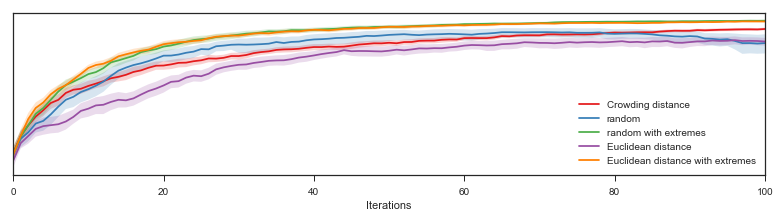

In [74]:
reference = compute_reference_point(logbooks)
print('Using reference point: ', reference)
hypervolumes, min_hyp, max_hyp = compute_hypervolumes(logbooks, reference)

In [184]:
def plot_compact(hypervolumes, hyp_lims=None, sample_size=50):
    plt.figure(figsize=(7,3))
    pal = sns.color_palette("Set2", len(hypervolumes))

    for idx, method in enumerate(sorted(hypervolumes)):
        means = np.mean(hypervolumes[method], axis=0)
        sns.tsplot(hypervolumes[method], err_style='ci_band', ci=95, n_boot=100, 
                       interpolate=False, color=pal[idx], marker=None)
        plt.plot(means, color=pal[idx], label=labels[idx], markevery=5,
                 marker=markers[idx], linestyle=linestyles[idx%len(linestyles)],linewidth=1,
                 markeredgewidth=1, markeredgecolor=pal[idx], markerfacecolor='None', alpha=1)
        
    plt.legend()
    plt.tight_layout()
    plt.xlabel('Iterations')

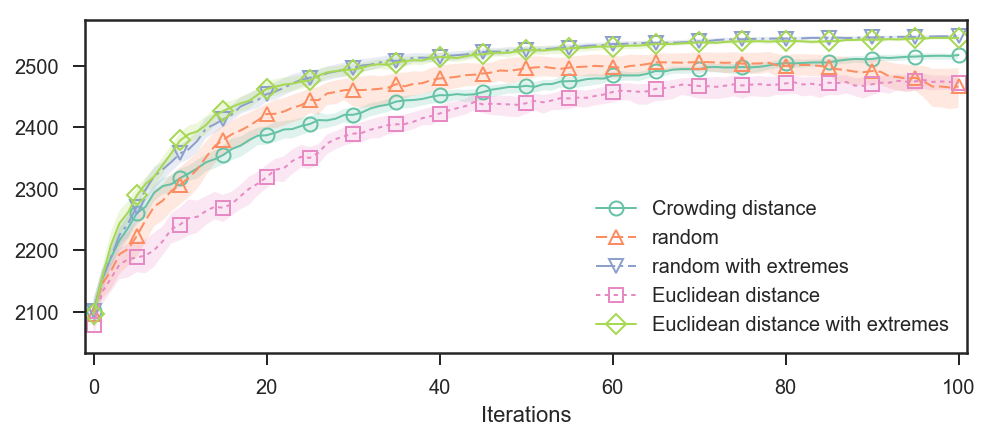

In [185]:
plot_compact(hypervolumes, (min_hyp, max_hyp))

* It is very intesting how the random selection that maintains the extremes matches the performance of crowding distance. 
* It is necessary to test for diversity on these results.

---

# Experiments with DTLZ7

Let's repeat the previous experiments but using DTLZ7.

In [49]:
def dtlz7(ind, n_objs):
    gval = 1 + 9.0 / len(ind[n_objs-1:]) * sum([a for a in ind[n_objs-1:]])
    fit = [ind for ind in ind[:n_objs-1]]
    fit.append((1 + gval) * (n_objs - sum([a / (1.0 + gval) * (1 + math.sin(3 * math.pi * a)) for a in ind[:n_objs-1]])))
    return fit

In [50]:
def dtlz7_instance(ind):
    return dtlz7(ind, number_of_objs)

In [51]:
toolbox.register("evaluate", dtlz7_instance)

In [52]:
toolbox.max_gen = 200

In [53]:
logbooks = {}

In [54]:
toolbox.register("select", tools.selNSGA2)
pool = Pool()
%time logbooks['01. Crowding distance'] = pool.map(run_algo, [toolbox] * number_of_runs)
pool.close()

CPU times: user 5.57 s, sys: 556 ms, total: 6.12 s
Wall time: 1min 1s


In [55]:
def sel_random(pop, k):
    return selection_custom(pop, k, distance=assign_random, 
                                  key='fitness.distance')
toolbox.register("select", sel_random)
pool = Pool()
%time logbooks['02. random'] = pool.map(run_algo, [toolbox] * number_of_runs)
pool.close()

CPU times: user 5.97 s, sys: 742 ms, total: 6.71 s
Wall time: 1min 10s


In [56]:
def sel_random_keep_extremes(pop, k):
    return selection_custom(pop, k, distance=assign_random_keep_extremes, 
                                  key='fitness.distance')
toolbox.register("select", sel_random_keep_extremes)
pool = Pool()
%time logbooks['03. random with extremes'] = pool.map(run_algo, [toolbox] * number_of_runs)
pool.close()

CPU times: user 5.53 s, sys: 819 ms, total: 6.35 s
Wall time: 1min 7s


In [57]:
def sel_euclidean(pop, k):
    return selection_custom(pop, k, distance=assign_euclidean, 
                                  key='fitness.distance')
toolbox.register("select", sel_euclidean)
pool = Pool()
%time logbooks['04. Euclidean distance'] = pool.map(run_algo, [toolbox] * number_of_runs)
pool.close()

CPU times: user 6.78 s, sys: 1.09 s, total: 7.87 s
Wall time: 8min 41s


In [58]:
def sel_euclidean_keep_extremes(pop, k):
    return selection_custom(pop, k, distance=assign_euclidean_keep_extremes, 
                                  key='fitness.distance')
toolbox.register("select", sel_euclidean_keep_extremes)
pool = Pool()
%time logbooks['05. Euclidean distance with extremes'] = pool.map(run_algo, [toolbox] * number_of_runs)
pool.close()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


Using reference point:  [  1.4999997    1.49999879   1.4999836    1.49999332  42.40754145]


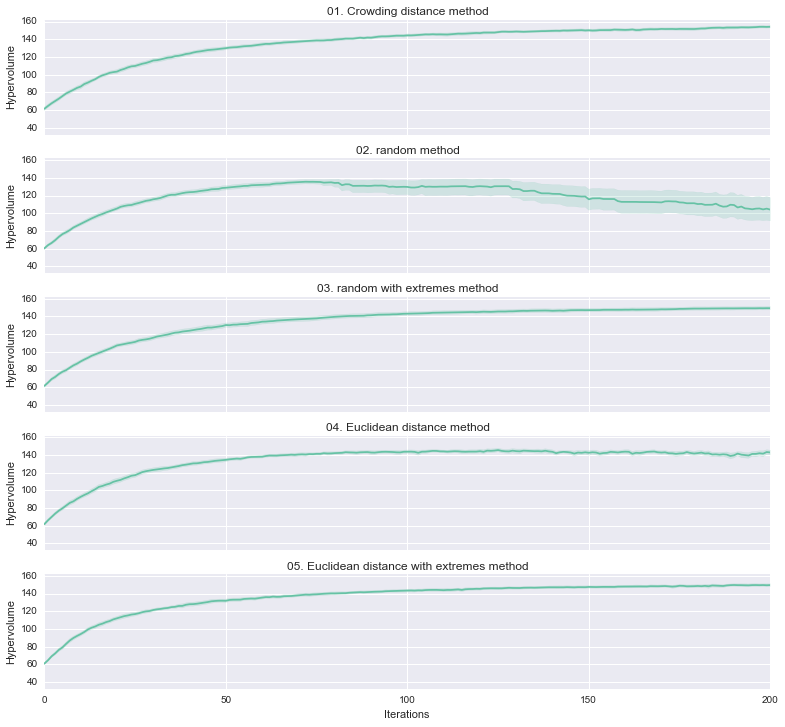

In [60]:
reference = compute_reference_point(logbooks)
print('Using reference point: ', reference)
hypervolumes, min_hyp, max_hyp = compute_hypervolumes(logbooks, reference)
plot_results(hypervolumes, (min_hyp, max_hyp))

---